This is based on 'bear_Final_model' released 2020/01/23

In [1]:
# Forked from excellent kernel : https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features
# From Kaggler : https://www.kaggle.com/jsaguiar
# Just added a few features so I thought I had to make release it as well...

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import csv

In [2]:
# Reading the saved dtypes Series
final_df_dtypes = \
pd.read_csv('../../../BDSE12-Group3/datasets/homecdt_ss_output/ss_fteng_fromBDSE12_03G_HomeCredit_V1_20200201b_dtypes_series.csv'\
            , header=None, index_col=0, squeeze=True)
del final_df_dtypes.index.name
final_df_dtypes = final_df_dtypes.to_dict()
final_df_dtypes

{'SK_ID_CURR': 'uint32',
 'AMT_REQ_CREDIT_BUREAU_DAY_1.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_DAY_2.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_DAY_3.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_DAY_4.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_DAY_5.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_DAY_6.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_DAY_8.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_DAY_9.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_HOUR_1.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_HOUR_2.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_HOUR_3.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_HOUR_4.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_MON_1.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_MON_10.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_MON_11.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_MON_12.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_MON_13.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_MON_14.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_MON_15.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_MON_16.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_MON_17.0': 'uint8',
 'AMT_REQ_CREDIT_BUREAU_MON_18.0': 'uint8',
 'AMT_REQ_CREDIT

In [3]:
# Apply the newly read csv with correct dtypes
# It seemed not necessary to transform it to dict: final_df_dtype_dict = final_df_dtype_dict.to_dict()
# final_df = final_df.astype(final_df_dtypes)
# # Or when reading the dataset csv (must transform it to dict)
# final_df = pd.read_csv('filepath', dtype = final_df_dtypes)

In [4]:
final_df = \
pd.read_csv('../../../BDSE12-Group3/datasets/homecdt_ss_output/ss_fteng_fromBDSE12_03G_HomeCredit_V1_20200201b.csv'\
           , dtype= final_df_dtypes)
# final_df = pd.read_csv('filepath', dtype = final_df_dtypes)

In [5]:
final_df.shape

(356255, 5782)

In [6]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 5782 entries, SK_ID_CURR to CC_('ccb_SK_DPD_delay_count', 'median')_median_na
dtypes: float32(498), int64(3), uint32(1), uint8(5280)
memory usage: 2.4 GB


In [7]:
# int_df.max().max(), int_df.min().min()

In [8]:
# float_df.max().max(), float_df.min().min()

In [9]:
# Do this only once for each dataset
def reduce_mem_usage3(props):
    props.info(verbose=False)
    
    int_colName = props.columns[props.dtypes == (np.int64 or np.int32)]
    float_colName = props.columns[props.dtypes == (np.float64 or np.float32)]
    int_df = props.loc[:, int_colName]
    float_df = props.loc[:, float_colName]
    print(int_df.shape)
    print(float_df.shape)
    
    assert int_df.shape[1] + float_df.shape[1] == props.shape[1]
    assert all(np.isfinite(int_df).all().value_counts())==True
    assert all(np.isfinite(float_df).all().value_counts())==True
    
    print("=============================================================")
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    print("=============================================================")
    print("Start working on integers...")
    int_df[int_df.columns[(int_df.min()>=0) & (int_df.max()<255)]] = \
    int_df.loc[:, int_df.columns[(int_df.min()>=0) & (int_df.max()<255)]].astype(np.uint8, copy=False)
    int_df.info(verbose=False)
    print("=============================================================")

    int_df[int_df.columns[(int_df.min()>=0) &(int_df.max() >= 255) & (int_df.max()<65535)]] = \
    int_df.loc[:, int_df.columns[(int_df.min()>=0) &(int_df.max() >= 255) & (int_df.max()<65535)]] \
    .astype(np.uint16, copy=False)
    int_df.info(verbose=False)
    print("=============================================================")

    int_df[int_df.columns[(int_df.min()>=0) &(int_df.max() >= 65535) & (int_df.max()<4294967295)]] = \
    int_df.loc[:, int_df.columns[(int_df.min()>=0) &(int_df.max() >= 65535) & (int_df.max()<4294967295)]] \
    .astype(np.uint32, copy=False)
    int_df.info(verbose=False)
    print("=============================================================")
    print("Start working on floats...")
    float_df = float_df.astype(np.float32)
    float_df.info(verbose=False)

#     props[props.columns[(props.min()>=0) &(props.max() >= 4294967295)]] = \
#     props.loc[:, props.columns[(props.min()>=0) &(props.max() >= 4294967295)]] \
#     .astype(np.uint64, copy=False)
#     props.info(verbose=False)
#     print("=============================================================")
    print("Combining ints & floats...")
    props = pd.concat([int_df, float_df], axis = 'columns')
    print("Complete")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    props.dtypes.to_csv('./final_df_dtypes.csv')
    print("./final_df_dtypes.csv was exported")
    
    return props

In [10]:
final_df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in final_df.columns]

In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 5782 entries, SK_ID_CURR to CC___ccb_SK_DPD_delay_count____median___median_na
dtypes: float32(498), int64(3), uint32(1), uint8(5280)
memory usage: 2.4 GB


In [12]:
# # Do this only once for each dataset, then use the exported dtype series.
# final_df = reduce_mem_usage3(final_df)

In [13]:
# Export the dtypes Series to csv for future use
# final_df.dtypes.to_csv('../../../BDSE12-Group3/datasets/homecdt_ss_output/ss_fteng_fromBDSE12_03G_HomeCredit_V1_20200201b_dtypes_series.csv')

In [14]:
print(final_df['TARGET'].isna().sum(), 
      final_df['TARGET'].dtypes)

48744 float32


# LightGBM 模型

In [15]:
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def kfold_lightgbm(df, num_folds = 5, stratified = True, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM goss. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=924)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=924)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                             label=train_df['TARGET'].iloc[train_idx], 
                             free_raw_data=False, silent=True)
        dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx], 
                             label=train_df['TARGET'].iloc[valid_idx], 
                             free_raw_data=False, silent=True)

        # LightGBM parameters found by Bayesian optimization
        params = {
            'objective': 'binary',
            'boosting_type': 'goss',
            'nthread': 4,
            'learning_rate': 0.02,  # 02,
            'num_leaves': 31, #20,33
#             'tree_learner': 'voting',
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'subsample_freq': 0,
            'max_depth': 7, #8,7
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_data_in_leaf': 49, # ss add
#             'min_child_weight': 1, # 60,39
            'seed': 924,
            'verbose': 2000,
            'metric': 'auc',
            'max_bin': 127,
#             'histogram_pool_size': 20480
#             'device' : 'gpu',
#             'gpu_platform_id': 0,
#             'gpu_device_id':0
        }
        
        clf = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=20000,
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds=200,
            verbose_eval=2000
        )

        oof_preds[valid_idx] = clf.predict(dvalid.data)
        sub_preds += clf.predict(test_df[feats]) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
        del clf, dtrain, dvalid
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        sub_df = test_df[['SK_ID_CURR']].copy()
        sub_df['TARGET'] = sub_preds
        sub_df[['SK_ID_CURR', 'TARGET']].to_csv('../../../BDSE12-Group3/datasets/homecdt_ss_output/homecdt_submission_LGBM.csv', index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout
    plt.savefig('../../../BDSE12-Group3/datasets/homecdt_ss_output/lgbm_importances01.png')

## boosting_type：goss

Starting LightGBM goss. Train shape: (307511, 5782), test shape: (48744, 5782)
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1606]	training's auc: 0.885111	valid_1's auc: 0.792017
Fold  1 AUC : 0.792017
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1460]	training's auc: 0.879203	valid_1's auc: 0.791171
Fold  2 AUC : 0.791171
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1541]	training's auc: 0.881741	valid_1's auc: 0.793401
Fold  3 AUC : 0.793401
Training until validation scores don't improve for 200 rounds
[2000]	training's auc: 0.899671	valid_1's auc: 0.797702
Early stopping, best iteration is:
[1945]	training's auc: 0.897831	valid_1's auc: 0.797857
Fold  4 AUC : 0.797857
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1763]	training's auc: 0.891358	valid_1's auc: 0.789865
Fold  5 

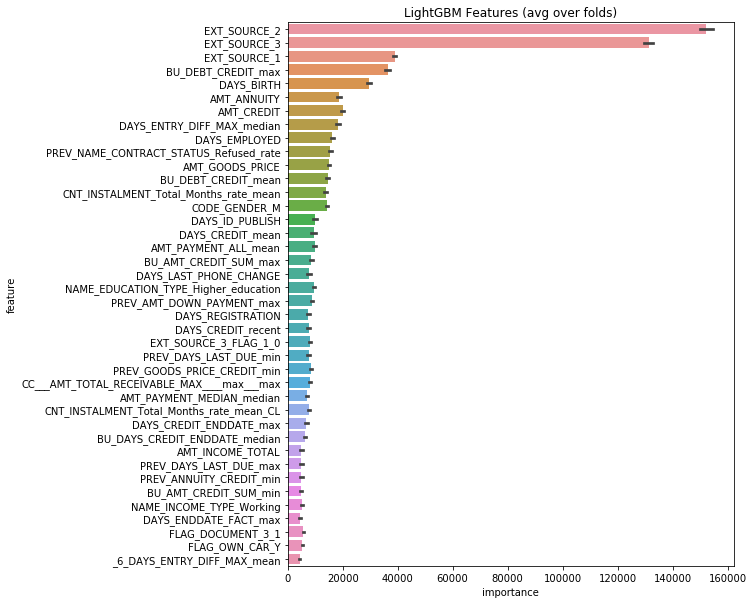

In [16]:
init_time = time.time()
kfold_lightgbm(final_df,10)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：gbdt

In [ ]:
init_time = time.time()
kfold_lightgbm(final_df, 10)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：dart

In [ ]:
init_time = time.time()
kfold_lightgbm(final_df,10)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：rf

In [ ]:
init_time = time.time()
kfold_lightgbm(final_df,10)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

# XGBoost 模型

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [ ]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle

In [ ]:
def kfold_xgb(df, num_folds, stratified = True, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting XGBoost. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        #if n_fold == 0: # REmove for full K-fold run
        cuda.select_device(0)
        cuda.close()
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = XGBClassifier(learning_rate =0.01, 
                            n_estimators=5000, 
                            max_depth=4, 
                            min_child_weight=5,
#                             tree_method='gpu_hist',
                            subsample=0.8, 
                            colsample_bytree=0.8, 
                            objective= 'binary:logistic',
                            nthread=4,
                            scale_pos_weight=2.5,
                            seed=28,
                            reg_lambda = 1.2)
        
#         clf = pickle.load(open('test.pickle','rb'))
        
        cuda.select_device(0)
        cuda.close()
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)
        
        cuda.select_device(0)
        cuda.close()
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats])[:, 1] # / folds.n_splits # - Uncomment for K-fold 

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

        np.save("xgb_oof_preds_1", oof_preds)
        np.save("xgb_sub_preds_1", sub_preds)
        
        cuda.select_device(0)
        cuda.close()
        
    
    clf = pickle.load(open('test.pickle','rb'))
    # print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_XGBoost_GPU.csv', index= False)
    #display_importances(feature_importance_df)
    #return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBoost Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('xgb_importances02.png')

In [ ]:
init_time = time.time()
kfold_xgb(final_df, 5)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))